<a href="https://www.kaggle.com/code/anhvinh/cycle-gan?scriptVersionId=222544580" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf

import os
import time
import torch
import pathlib

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from IPython import display

In [2]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BUFFER_SIZE = 400
BATCH_SIZE = 4
NUM_EPOCHS = 100

# Dataset

In [3]:
dataset_name = "facades"

In [4]:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

30168306/30168306 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [5]:
list(PATH.parent.iterdir())

[PosixPath('/root/.keras/datasets/facades.tar.gz'),
 PosixPath('/root/.keras/datasets/facades')]

In [6]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


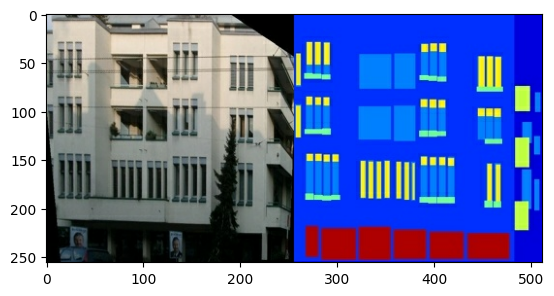

In [7]:
plt.figure()
plt.imshow(sample_image)

In [8]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

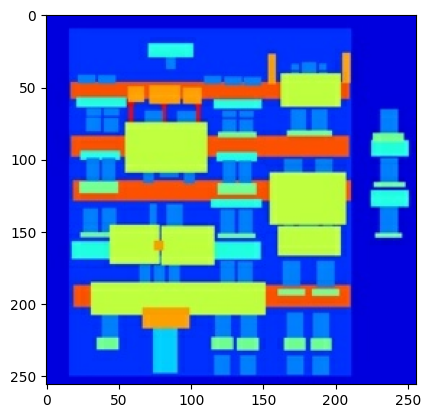

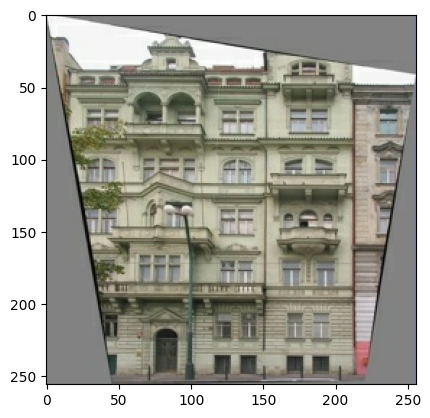

In [9]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [10]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [11]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [12]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [13]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [14]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

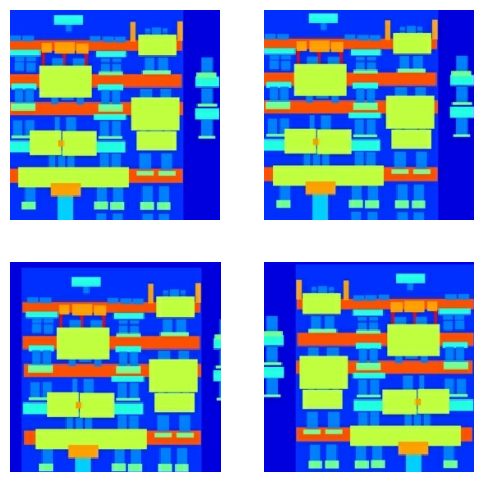

In [15]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [16]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [17]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [18]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(32)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [19]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Model

## Generator

In [20]:
# Thay thế Instance Normalization tự định nghĩa bằng BatchNormalization vì TF không hỗ trợ (PyTorch có)
def convolutional_block(x, filters, kernel_size=3, strides=2, padding='same'):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    x = layers.Conv2D(filters, kernel_size, strides, padding, kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def residual_block(x, filters, kernel_size=3, strides=1, padding='same'):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides, padding, kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, strides, padding, kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)
    return x

# Fractionally-strided convolution
def upsample_block(x, filters, kernel_size=3, strides=2, padding='same'):
    initializer = tf.random_normal_initializer(0., 0.02)
    # x = layers.UpSampling2D(size=2)(x)
    # x = layers.Conv2D(filters, kernel_size, strides, padding)(x)
    x = layers.Conv2DTranspose(filters, kernel_size, strides, padding, kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

In [21]:
def build_generator(input_shape, conv_num, res_num, upsample_num):
    filters = 64
    inputs = layers.Input(shape=input_shape)
    
    x = convolutional_block(x=inputs, filters=filters, kernel_size=7, strides=1)
    for _ in range(conv_num-1):
        filters *= 2
        x = convolutional_block(x=x, filters=filters)

    for _ in range(res_num):
        x = residual_block(x=x, filters=filters, kernel_size=3)
  
    for _ in range(upsample_num):
        filters = max(64, int(filters/2))
        x = upsample_block(x, filters)
    initializer = tf.random_normal_initializer(0., 0.02)
    # Mapping features to RGB
    outputs = layers.Conv2D(filters=3, kernel_size=7, strides=1, padding='same', kernel_initializer=initializer, activation='tanh')(x)
    model = models.Model(inputs, outputs)
    return model

In [22]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
conv_num = 3
res_num = 6 if input_shape[0] == 128 else 9
up_num = 2

In [23]:
# G will mapping from X to Y
generator_G = build_generator(input_shape, conv_num, res_num, up_num)

# F will mapping from Y to X
generator_F = build_generator(input_shape, conv_num, res_num, up_num)

## Discriminator

In [24]:
def discriminator_block(x, filters, kernel_size=4, strides=2, padding='same', norm=True, act=True):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    if norm: x = layers.BatchNormalization()(x)
    if act: x = layers.LeakyReLU(negative_slope=0.2)(x)
    return x

def build_discriminator(input_shape):
    inp = layers.Input(shape=input_shape, name='input_image')
    tar = layers.Input(shape=input_shape, name='target_image')

    x = layers.Concatenate()([inp, tar])
    
    filters = 64
    n_down = 3
    x = discriminator_block(x, filters, norm=False)
    for i in range(n_down):
        x = discriminator_block(x, filters*2**(i+1), strides=1 if i == (n_down-1) else 2)
    out = discriminator_block(x, 1, strides=1, norm=False, act=False)
    model = models.Model(inputs=[inp, tar], outputs=[out])
    return model

In [25]:
discriminator_Y = build_discriminator(input_shape)
discriminator_X = build_discriminator(input_shape)

# Losses

In [26]:
LAMDA = 10

In [27]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    return gan_loss

In [29]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.reduce_mean(tf.square(tf.ones_like(disc_real_output) - disc_real_output))
    
    generated_loss = tf.reduce_mean(tf.square(tf.zeros_like(disc_generated_output) - disc_generated_output))
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

# Optimizier

In [30]:
class LinearDecaySchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, lr, step_per_epoch):
        self.lr = lr
        self.final_lr = 0
        self.step_per_epoch = step_per_epoch

    def __call__(self, step):
        epoch = tf.cast(step, tf.float32) // tf.cast(self.step_per_epoch, tf.float32)

        # Use tf.cond() to avoid graph errors
        return tf.cond(
            epoch < 100,
            lambda: self.lr,  # If in warmup, return initial LR
            lambda: self.lr - ((self.lr - self.final_lr) * (epoch - 100) / epoch)  # Else, decay LR
        )

In [31]:
lr = 2e-4
step_per_epoch = len(train_dataset)
lr_scheduler = LinearDecaySchedule(lr, step_per_epoch)

In [32]:
optimizer_G = tf.keras.optimizers.Adam(lr_scheduler)
optimizer_F = tf.keras.optimizers.Adam(lr_scheduler)
optimizer_X = tf.keras.optimizers.Adam(lr_scheduler)
optimizer_Y = tf.keras.optimizers.Adam(lr_scheduler)

# Generate images

In [33]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])

        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

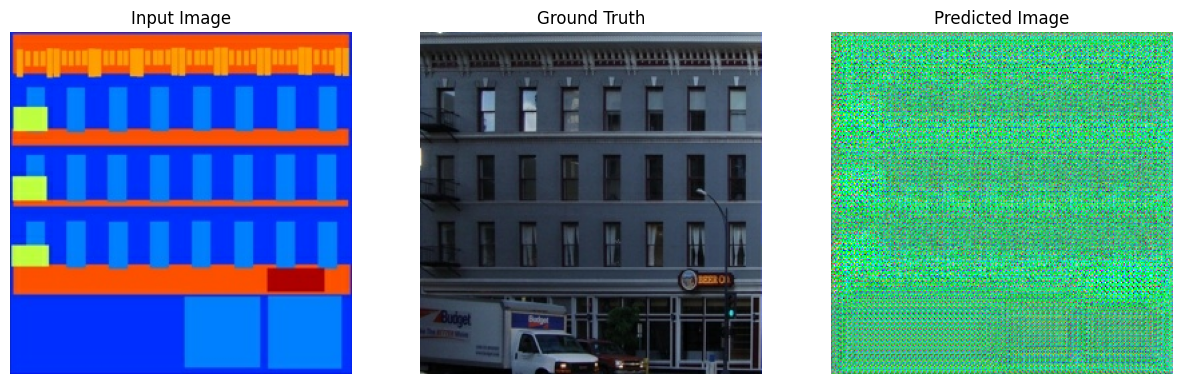

In [34]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator_G, example_input, example_target)

In [35]:
checkpoint_path = "/kaggle/working/"

ckpt = tf.train.Checkpoint(generator_G=generator_G,
                           generator_F=generator_F,
                           discriminator_X=discriminator_X,
                           discriminator_Y=discriminator_Y,
                           optimizer_G=optimizer_G,
                           optimizer_F=optimizer_F,
                           optimizer_X=optimizer_X,
                           optimizer_Y=optimizer_Y)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


# Training

In [36]:
@tf.function
def train_step(input_image, target_image):
    with tf.GradientTape(persistent=True) as tape:
        # GAN Loss of Generator G mapping from X -> Y
        fake_Y = generator_G(input_image, training=True)
        
        disc_real_Y = discriminator_Y([input_image, target_image], training=True)
        disc_fake_Y = discriminator_Y([input_image, fake_Y], training=True)
        
        G_gan_loss = tf.reduce_mean(tf.square(tf.ones_like(disc_fake_Y) - disc_fake_Y))
        Y_disc_loss = discriminator_loss(disc_real_Y, disc_fake_Y)

        # GAN Loss of Generator F mapping from Y -> X
        fake_X = generator_F(target_image, training=True)
        
        disc_real_X = discriminator_X([target_image, input_image], training=True)
        disc_fake_X = discriminator_X([target_image, fake_X], training=True)

        F_gan_loss = tf.reduce_mean(tf.square(tf.ones_like(disc_fake_X) - disc_fake_X))
        X_disc_loss = discriminator_loss(disc_real_X, disc_fake_X)

        # Cycle-Consistent Loss
        cycled_Y = generator_G(fake_X, training=True)
        cycled_X = generator_F(fake_Y, training=True)
        G_l1_loss = tf.reduce_mean(tf.abs(target_image - cycled_Y))
        F_l1_loss = tf.reduce_mean(tf.abs(input_image - cycled_X))

        cycle_loss = G_l1_loss + F_l1_loss
        total_loss = G_gan_loss + F_gan_loss + cycle_loss * LAMDA
    
    # Calculate gradients for generators
    G_gradients = tape.gradient(total_loss, generator_G.trainable_variables)
    F_gradients = tape.gradient(total_loss, generator_F.trainable_variables)

    # Calculate gradients for discriminators
    Y_gradients = tape.gradient(Y_disc_loss, discriminator_Y.trainable_variables)
    X_gradients = tape.gradient(X_disc_loss, discriminator_X.trainable_variables)

    # Apply gradients to the optimizers
    optimizer_G.apply_gradients(zip(G_gradients, generator_G.trainable_variables))
    optimizer_F.apply_gradients(zip(F_gradients, generator_F.trainable_variables))

    optimizer_Y.apply_gradients(zip(Y_gradients, discriminator_Y.trainable_variables))
    optimizer_X.apply_gradients(zip(X_gradients, discriminator_X.trainable_variables))
    
    return G_gan_loss, Y_disc_loss, F_gan_loss, X_disc_loss, total_loss

In [37]:
num_sample = len(train_dataset)

In [38]:
def fit(train_ds, test_ds, start_epoch=0, end_epoch=100):
    example_input, example_target = next(iter(test_ds.take(1)))

    for epoch in range(start_epoch, end_epoch):
        train_G_loss = 0.0
        train_Y_loss = 0.0
        train_F_loss = 0.0
        train_X_loss = 0.0
        total_loss = 0.0
        
        # Training and display the progress with every 10%
        print(f"Epoch {epoch + 1}/{end_epoch}")
        start = time.time()

        for step, (input_image, target) in train_ds.enumerate():
            
            G_loss, Y_loss, F_loss, X_loss, total = train_step(input_image, target)
            train_G_loss += G_loss
            train_Y_loss += Y_loss
            train_F_loss += F_loss
            train_X_loss += X_loss
            total_loss += total
  
            if (step+1) % (num_sample // 10) == 0:
                print('.', end='', flush=True)
             
        display.clear_output(wait=True)
        
        print(f"Time: {time.time() - start:.2f} sec\n"
        f"G Loss: {train_G_loss/num_sample}, Y Loss: {train_Y_loss/num_sample}\n"
        f"F Loss: {train_F_loss/num_sample}, X Loss: {train_X_loss/num_sample}\n"
        f"Total Loss: {total_loss/num_sample}")

        # Display an instance
        generate_images(generator_G, example_input, example_target)
        generate_images(generator_F, example_target, example_input)
        
        # Save the checkpoint
        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

In [39]:
# fit(train_dataset, test_dataset, 100, 200)

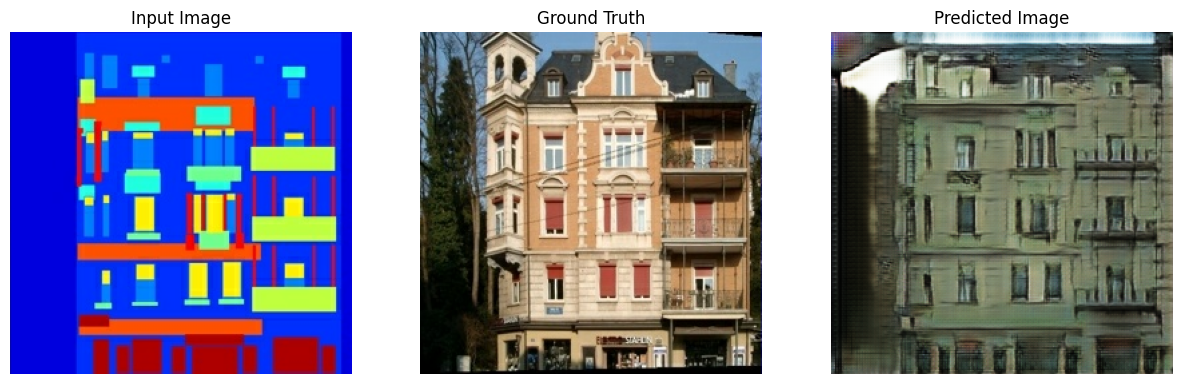

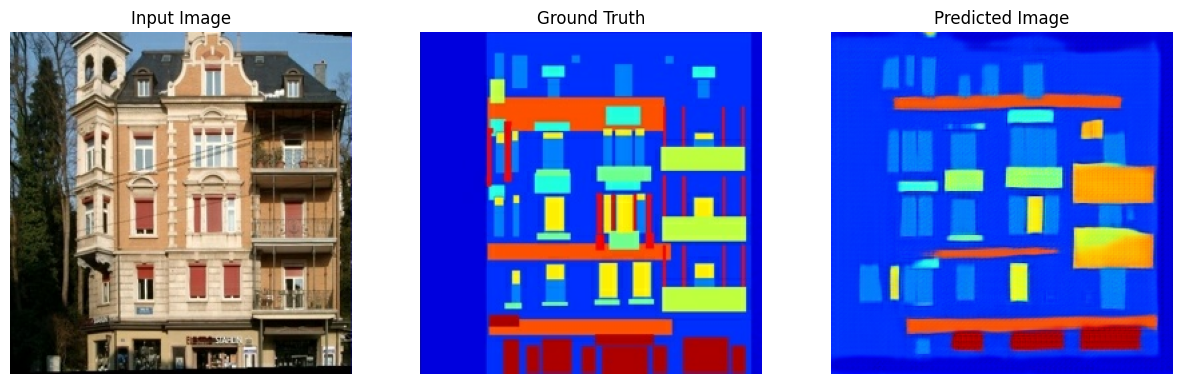

In [40]:
example_input, example_target = next(iter(test_dataset.take(1)))
generate_images(generator_G, example_input, example_target)
generate_images(generator_F, example_target, example_input)

# Evaluate

In [41]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

In [42]:
def compute_fcn_scores(model_G, model_F, dataset):
    stoi = []
    itos = []

    for image, y_true  in dataset:
        y_pred_a = model_G.predict([image], verbose=0)  # Add batch dimension
        y_pred_b = model_F.predict([y_true], verbose=0)
        
        y_true = y_true[0].numpy().astype(np.float32)
        stoi.append(ssim(y_true,
                      y_pred_a[0],
                      data_range=y_pred_a[0].max() - y_pred_a[0].min(),
                      channel_axis=-1))
        
        image = image[0].numpy().astype(np.float32)
        itos.append(ssim(image,
                      y_pred_b[0],
                      data_range=y_pred_b[0].max() - y_pred_b[0].min(),
                      channel_axis=-1))
        
    return {
        "Segmentation -> Image": np.mean(stoi),
        "Image -> Segmentation": np.mean(itos)
    }

In [43]:
compute_fcn_scores(generator_G, generator_F, train_dataset)

I0000 00:00:1739545468.014948      70 service.cc:145] XLA service 0x79babc01b310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739545468.015010      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1739545469.034611      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


{'Segmentation -> Image': 0.017773358, 'Image -> Segmentation': 0.38392356}

In [44]:
compute_fcn_scores(generator_G, generator_F, test_dataset)

{'Segmentation -> Image': 0.0285885, 'Image -> Segmentation': 0.39668155}